**Program**: 3_NSCH_AHR_Cluster_Analysis<br>
**Class**: Fall 2025, Machine Learning, Project<br>
**Member**: Vanessa Thorsten<br>
**Description**: This program reads in the analysis dataset NSCH_AHR_state.csv, which provides data summarized at the state-level. The following variables are kept and standardized, and cluster analysis is performed.<br>
- Percent of children receiving at least one preventative care visit<br>
- Percent of the population who are uninsured<br>

The clustering is compared to good immunization coverage by state.<br>

**Outputs**: The following data visualizations are provided for the dataset:<br>
- Q2_uninsured_pcare_good_immun_kmeans.png
- Q2_uninsured_pcare_good_immun_kmeans_correct.png
- Q2_uninsured_pcare_good_immun_dendrogram.png
- Q2_uninsured_pcare_good_immun_hc_correct.png
  
**Program History/Modifications**:<br>
09/15/2025    Initial Version

In [1]:
#Read in packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster


In [2]:
#bug with using KMeans in windows. Address by setting the environment
#Warning said, "KMeans is known to have a memory leak on Windows with MKL, 
#when there are less chunks than available threads. You can avoid it by 
#setting the environment variable OMP_NUM_THREADS=1."
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
#Combined state level data
df_state = pd.read_csv("NSCH_AHR_state.csv")
df_state.head()

,Unnamed: 0,STATE,nomChHlthSt_23_1.0_proportion,nomChHlthSt_23_2.0_proportion,PrevMed_23_1.0_proportion,PrevMed_23_2.0_proportion,K4Q01_1.0_proportion,K4Q01_2.0_proportion,smAdeqIns_23_1.0_proportion,smAdeqIns_23_2.0_proportion,...,immunizations,complete_hs,population_LT18,Poverty,primary_care_providers,public_health,support_engagement_annual,Uninsured,good_immun_cat,Region
0,0,AK,0.9245,0.0755,0.7562,0.2438,0.8580,0.1420,0.6341,0.3659,...,59.8,93.2,23.9,10.4,359.3,334.0,0.024,10.4,Low,West
1,1,AL,0.9022,0.0978,0.7939,0.2061,0.8134,0.1866,0.7404,0.2596,...,62.6,89.1,22.1,16.0,241.0,137.0,-0.745,8.5,Low,South
2,2,AR,0.9153,0.0847,0.7550,0.2450,0.7856,0.2144,0.6842,0.3158,...,62.0,89.3,23.0,16.3,241.4,128.0,-1.020,8.9,Low,South
3,3,AZ,0.8792,0.1208,0.7597,0.2403,0.7400,0.2600,0.6240,0.3760,...,62.9,89.4,21.3,12.6,258.2,84.0,0.125,9.9,Low,West
4,4,CA,0.8839,0.1161,0.7497,0.2503,0.7087,0.2913,0.7053,0.2947,...,59.8,84.8,21.7,12.0,229.7,173.0,0.199,6.4,Low,West


In [4]:
#Combined individual level data
df_fam = pd.read_csv("NSCH_fam.csv")
df_fam.head()

,Unnamed: 0,FIPSST,STATE,STATE_NAME,STRATUM,HHID,FORMTYPE,TOTKIDS_R,FWC,SC_AGE_YEARS,...,K4Q01,GOWHENSICK,UsualSck_23,smAdeqIns_23,smForgoneHC_23,nomAnxietyDep12to17_23,nomFlrish6mto5_23,nomFlrish6to17_23,ScreenTime_23,HrsSleep_23
0,0,6,CA,California,1,23043707,2,1,1318.476840,11,...,2.0,NaN,2.0,1.0,2.0,NaN,90.0,2.0,4.0,2.0
1,1,6,CA,California,1,23120547,3,2,978.499881,14,...,1.0,1.0,1.0,1.0,2.0,2.0,90.0,1.0,5.0,1.0
2,2,6,CA,California,1,23197456,3,1,904.191765,17,...,1.0,NaN,NaN,1.0,2.0,2.0,90.0,1.0,4.0,1.0
3,3,6,CA,California,1,23197458,3,2,1092.097256,12,...,1.0,1.0,1.0,1.0,2.0,2.0,90.0,1.0,4.0,1.0
4,4,6,CA,California,1,23235909,2,2,586.387870,10,...,2.0,NaN,2.0,2.0,2.0,NaN,90.0,1.0,5.0,1.0


In [5]:
df_fam['FWC'].describe()

count    54159.000000
mean      1302.431294
std       2331.079332
min         11.006690
25%        262.159242
50%        636.542554
75%       1410.243192
max      54078.402190
Name: FWC, dtype: float64

In [6]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     51 non-null     int64  
 1   STATE                          51 non-null     object 
 2   nomChHlthSt_23_1.0_proportion  51 non-null     float64
 3   nomChHlthSt_23_2.0_proportion  51 non-null     float64
 4   PrevMed_23_1.0_proportion      51 non-null     float64
 5   PrevMed_23_2.0_proportion      51 non-null     float64
 6   K4Q01_1.0_proportion           51 non-null     float64
 7   K4Q01_2.0_proportion           51 non-null     float64
 8   smAdeqIns_23_1.0_proportion    51 non-null     float64
 9   smAdeqIns_23_2.0_proportion    51 non-null     float64
 10  healthy                        51 non-null     float64
 11  preventative_care              51 non-null     float64
 12  place_for_care                 51 non-null     float

In [7]:
df_state.describe()

,Unnamed: 0,nomChHlthSt_23_1.0_proportion,nomChHlthSt_23_2.0_proportion,PrevMed_23_1.0_proportion,PrevMed_23_2.0_proportion,K4Q01_1.0_proportion,K4Q01_2.0_proportion,smAdeqIns_23_1.0_proportion,smAdeqIns_23_2.0_proportion,healthy,...,place_for_care,insurance,immunizations,complete_hs,population_LT18,Poverty,primary_care_providers,public_health,support_engagement_annual,Uninsured
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,50.000000,51.000000
mean,25.000000,0.907971,0.092029,0.802661,0.197339,0.799275,0.200725,0.667253,0.332747,90.794118,...,79.923529,66.725490,67.900000,91.213725,21.639216,12.590196,301.358824,154.196078,-0.135260,7.184314
std,14.866069,0.020598,0.020598,0.041970,0.041970,0.044400,0.044400,0.041641,0.041641,2.057611,...,4.444844,4.162203,5.146688,2.355421,1.921674,2.505215,55.170631,145.507803,0.478203,2.681520
min,0.000000,0.862100,0.046200,0.698000,0.107300,0.696900,0.114100,0.589800,0.216700,86.200000,...,69.700000,59.000000,57.800000,84.800000,17.700000,8.300000,221.000000,66.000000,-1.020000,2.600000
25%,12.500000,0.893700,0.075900,0.775050,0.176600,0.767500,0.173800,0.634000,0.309250,89.400000,...,76.700000,63.400000,64.300000,89.550000,20.500000,11.050000,265.150000,96.000000,-0.555500,5.400000
50%,25.000000,0.909600,0.090400,0.801600,0.198400,0.799300,0.200700,0.658300,0.341700,91.000000,...,79.900000,65.800000,67.700000,91.400000,21.600000,12.200000,298.600000,123.000000,-0.022500,6.500000
75%,37.500000,0.924100,0.106300,0.823400,0.224950,0.826200,0.232500,0.690750,0.366000,92.400000,...,82.600000,69.100000,70.400000,93.050000,23.000000,13.650000,327.950000,156.500000,0.239500,9.000000
max,50.000000,0.953800,0.137900,0.892700,0.302000,0.885900,0.303100,0.783300,0.410200,95.400000,...,88.600000,78.300000,83.100000,95.500000,27.300000,19.500000,553.600000,1084.000000,0.750000,16.400000


### Standardization

In [8]:
df_state[['healthy', 'preventative_care','place_for_care',
'insurance','immunizations','complete_hs','population_LT18',
'Poverty','primary_care_providers','public_health',
'Uninsured']].describe().round(2)

,healthy,preventative_care,place_for_care,insurance,immunizations,complete_hs,population_LT18,Poverty,primary_care_providers,public_health,Uninsured
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00
mean,90.79,80.27,79.92,66.73,67.90,91.21,21.64,12.59,301.36,154.20,7.18
std,2.06,4.20,4.44,4.16,5.15,2.36,1.92,2.51,55.17,145.51,2.68
min,86.20,69.80,69.70,59.00,57.80,84.80,17.70,8.30,221.00,66.00,2.60
25%,89.40,77.50,76.70,63.40,64.30,89.55,20.50,11.05,265.15,96.00,5.40
50%,91.00,80.20,79.90,65.80,67.70,91.40,21.60,12.20,298.60,123.00,6.50
75%,92.40,82.35,82.60,69.10,70.40,93.05,23.00,13.65,327.95,156.50,9.00
max,95.40,89.30,88.60,78.30,83.10,95.50,27.30,19.50,553.60,1084.00,16.40


In [9]:
#Don't include 'healthy' or 'preventative_care' as these are the types of
#outcomes we are interested in predicting

cols_for_clustering = ['place_for_care',
'insurance','immunizations','complete_hs','population_LT18',
'Poverty','primary_care_providers','public_health', 'preventative_care',
'Uninsured']

df_filtered = df_state[cols_for_clustering]

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_filtered), 
                            columns=df_filtered.columns, index=df_filtered.index)

#Add 'STATE', healthy and preventative care back to the standardized DataFrame
df_state_std = pd.concat(
    [df_scaled, df_state[['STATE', 'healthy', 'support_engagement_annual', 'good_immun_cat']]], 
    axis=1
)

print(df_state_std.head())
print(df_state_std.columns)

   place_for_care  insurance  immunizations  complete_hs  population_LT18  \
0        1.335243  -0.806924      -1.589488     0.851669         1.188172   
1        0.312760   1.765146      -1.040035    -0.906317         0.242169   
2       -0.300730   0.406317      -1.157775    -0.820562         0.715171   
3       -1.345935  -1.049572      -0.981165    -0.777684        -0.178277   
4       -2.050312   0.915877      -1.589488    -2.750058         0.031946   

    Poverty  primary_care_providers  public_health  preventative_care  \
0 -0.882954                1.060668       1.247995          -1.122213   
1  1.374626               -1.104925      -0.119356          -0.208795   
2  1.495568               -1.097603      -0.181824          -1.146250   
3  0.003952               -0.790063      -0.487222          -1.026063   
4 -0.237931               -1.311782       0.130516          -1.266437   

   Uninsured STATE  healthy  support_engagement_annual good_immun_cat  
0   1.211135    AK     92.

In [10]:
df_state_std[['place_for_care', 'insurance','immunizations',
              'complete_hs','population_LT18', 'Poverty',
              'primary_care_providers','public_health','preventative_care',
              'support_engagement_annual','Uninsured']].describe().round(2)

,place_for_care,insurance,immunizations,complete_hs,population_LT18,Poverty,primary_care_providers,public_health,preventative_care,support_engagement_annual,Uninsured
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,50.00,51.00
mean,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.14,0.00
std,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,0.48,1.01
min,-2.32,-1.87,-1.98,-2.75,-2.07,-1.73,-1.47,-0.61,-2.52,-1.02,-1.73
25%,-0.73,-0.81,-0.71,-0.71,-0.60,-0.62,-0.66,-0.40,-0.67,-0.56,-0.67
50%,-0.01,-0.22,-0.04,0.08,-0.02,-0.16,-0.05,-0.22,-0.02,-0.02,-0.26
75%,0.61,0.58,0.49,0.79,0.72,0.43,0.49,0.02,0.50,0.24,0.68
max,1.97,2.81,2.98,1.84,2.98,2.79,4.62,6.45,2.17,0.75,3.47


In [11]:
df_state_std['good_immun_cat'].value_counts()

good_immun_cat
Medium or high    26
Low               25
Name: count, dtype: int64

In [12]:
#New variable for good health at 90% or more
health_bins = [0, 90.0, 92.0, 99.99]
health_labels = ['low','med','high']
df_state_std['good_health_cat'] = pd.cut(df_state_std['healthy'], 
                                         bins=health_bins, labels=health_labels, 
                                         right=False)

df_state_std['good_health_cat'].value_counts()

good_health_cat
med     19
high    17
low     15
Name: count, dtype: int64

In [13]:
# Variables of interest
df_cluster = df_state_std[['STATE','place_for_care', 'insurance','immunizations',
                           'Poverty', 'primary_care_providers','public_health',
                           'support_engagement_annual','complete_hs','preventative_care',
                           'population_LT18','Uninsured']]

#Add variables to the cluster dataset
# Merge columns into df_cluster
df_cluster = df_cluster.merge(
    df_state_std[['STATE', 'good_health_cat', 'good_immun_cat']],
    on='STATE',
    how='left'  # or 'inner' if you only want matching states
)

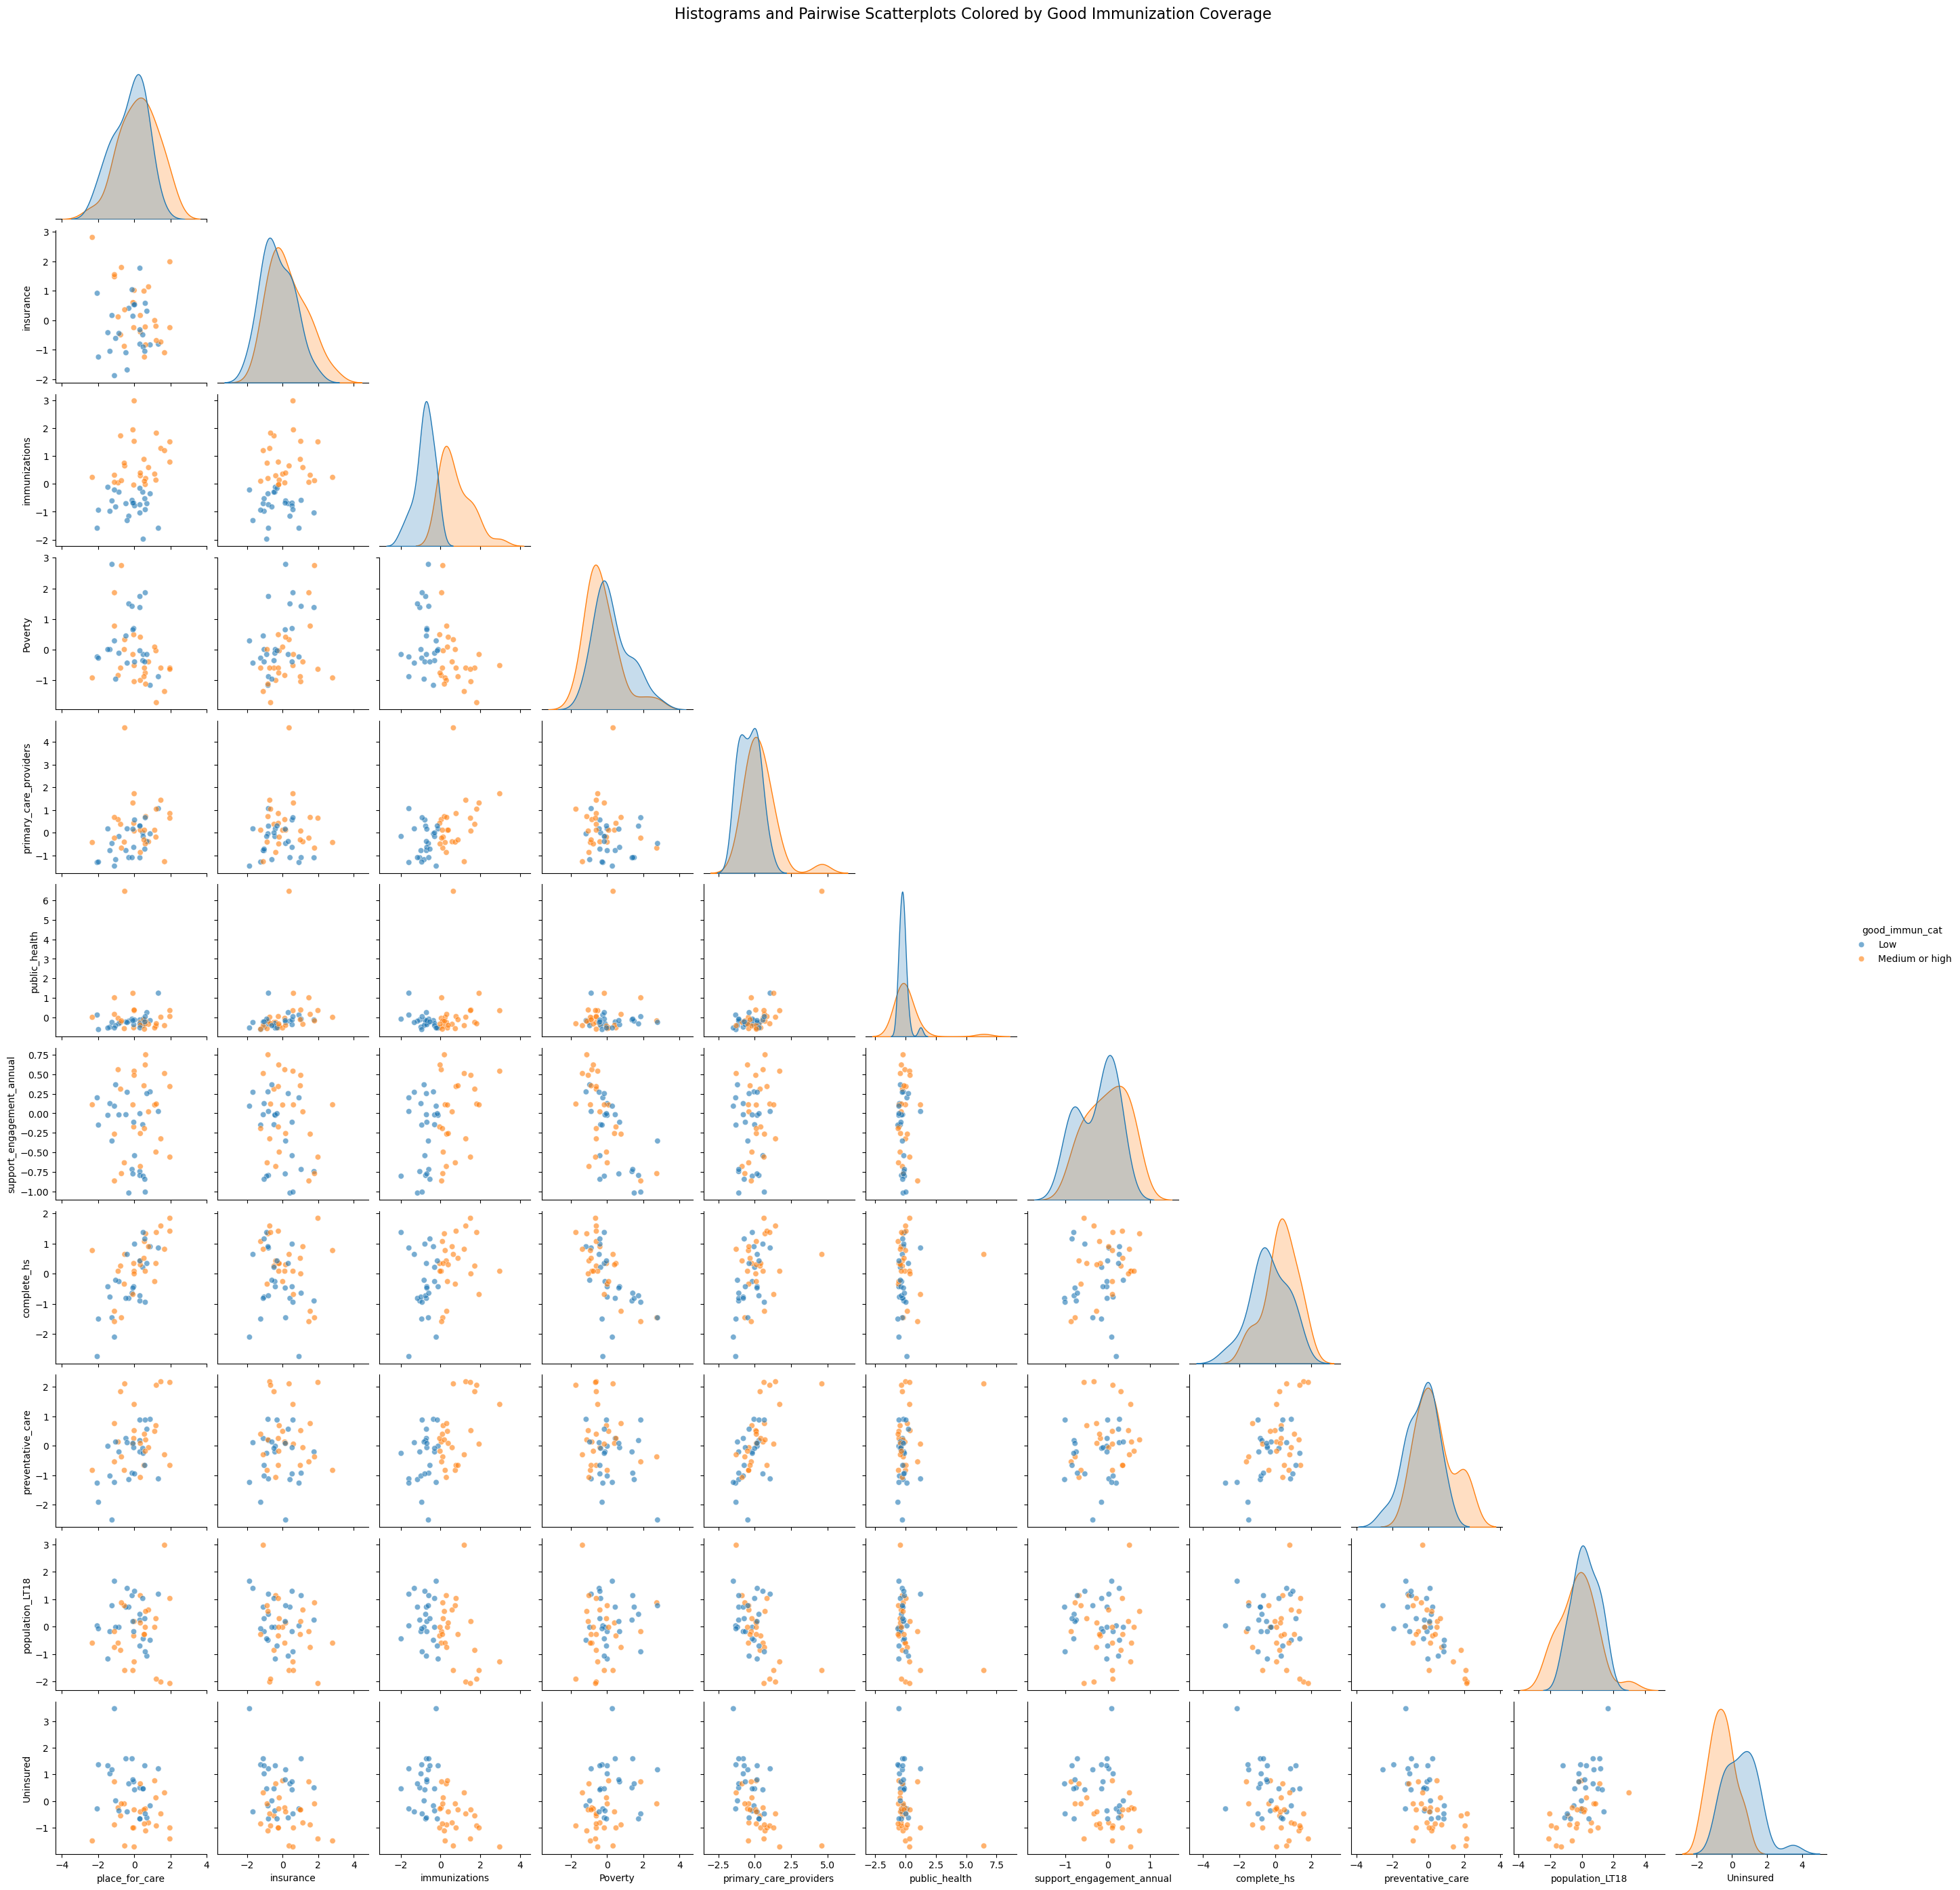

In [14]:
#Panel histograms and scatterplots with pairwise comparisons

# Create pairplot with hue
sns.pairplot(df_cluster, 
             hue='good_immun_cat', 
             kind='scatter', 
             corner=True, 
             plot_kws={'alpha': 0.6})

# Add a title
plt.suptitle('Histograms and Pairwise Scatterplots Colored by Good Immunization Coverage', fontsize=16, y=1.02)

# Show plot
plt.show()

C:\Users\vromm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vromm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vromm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vromm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

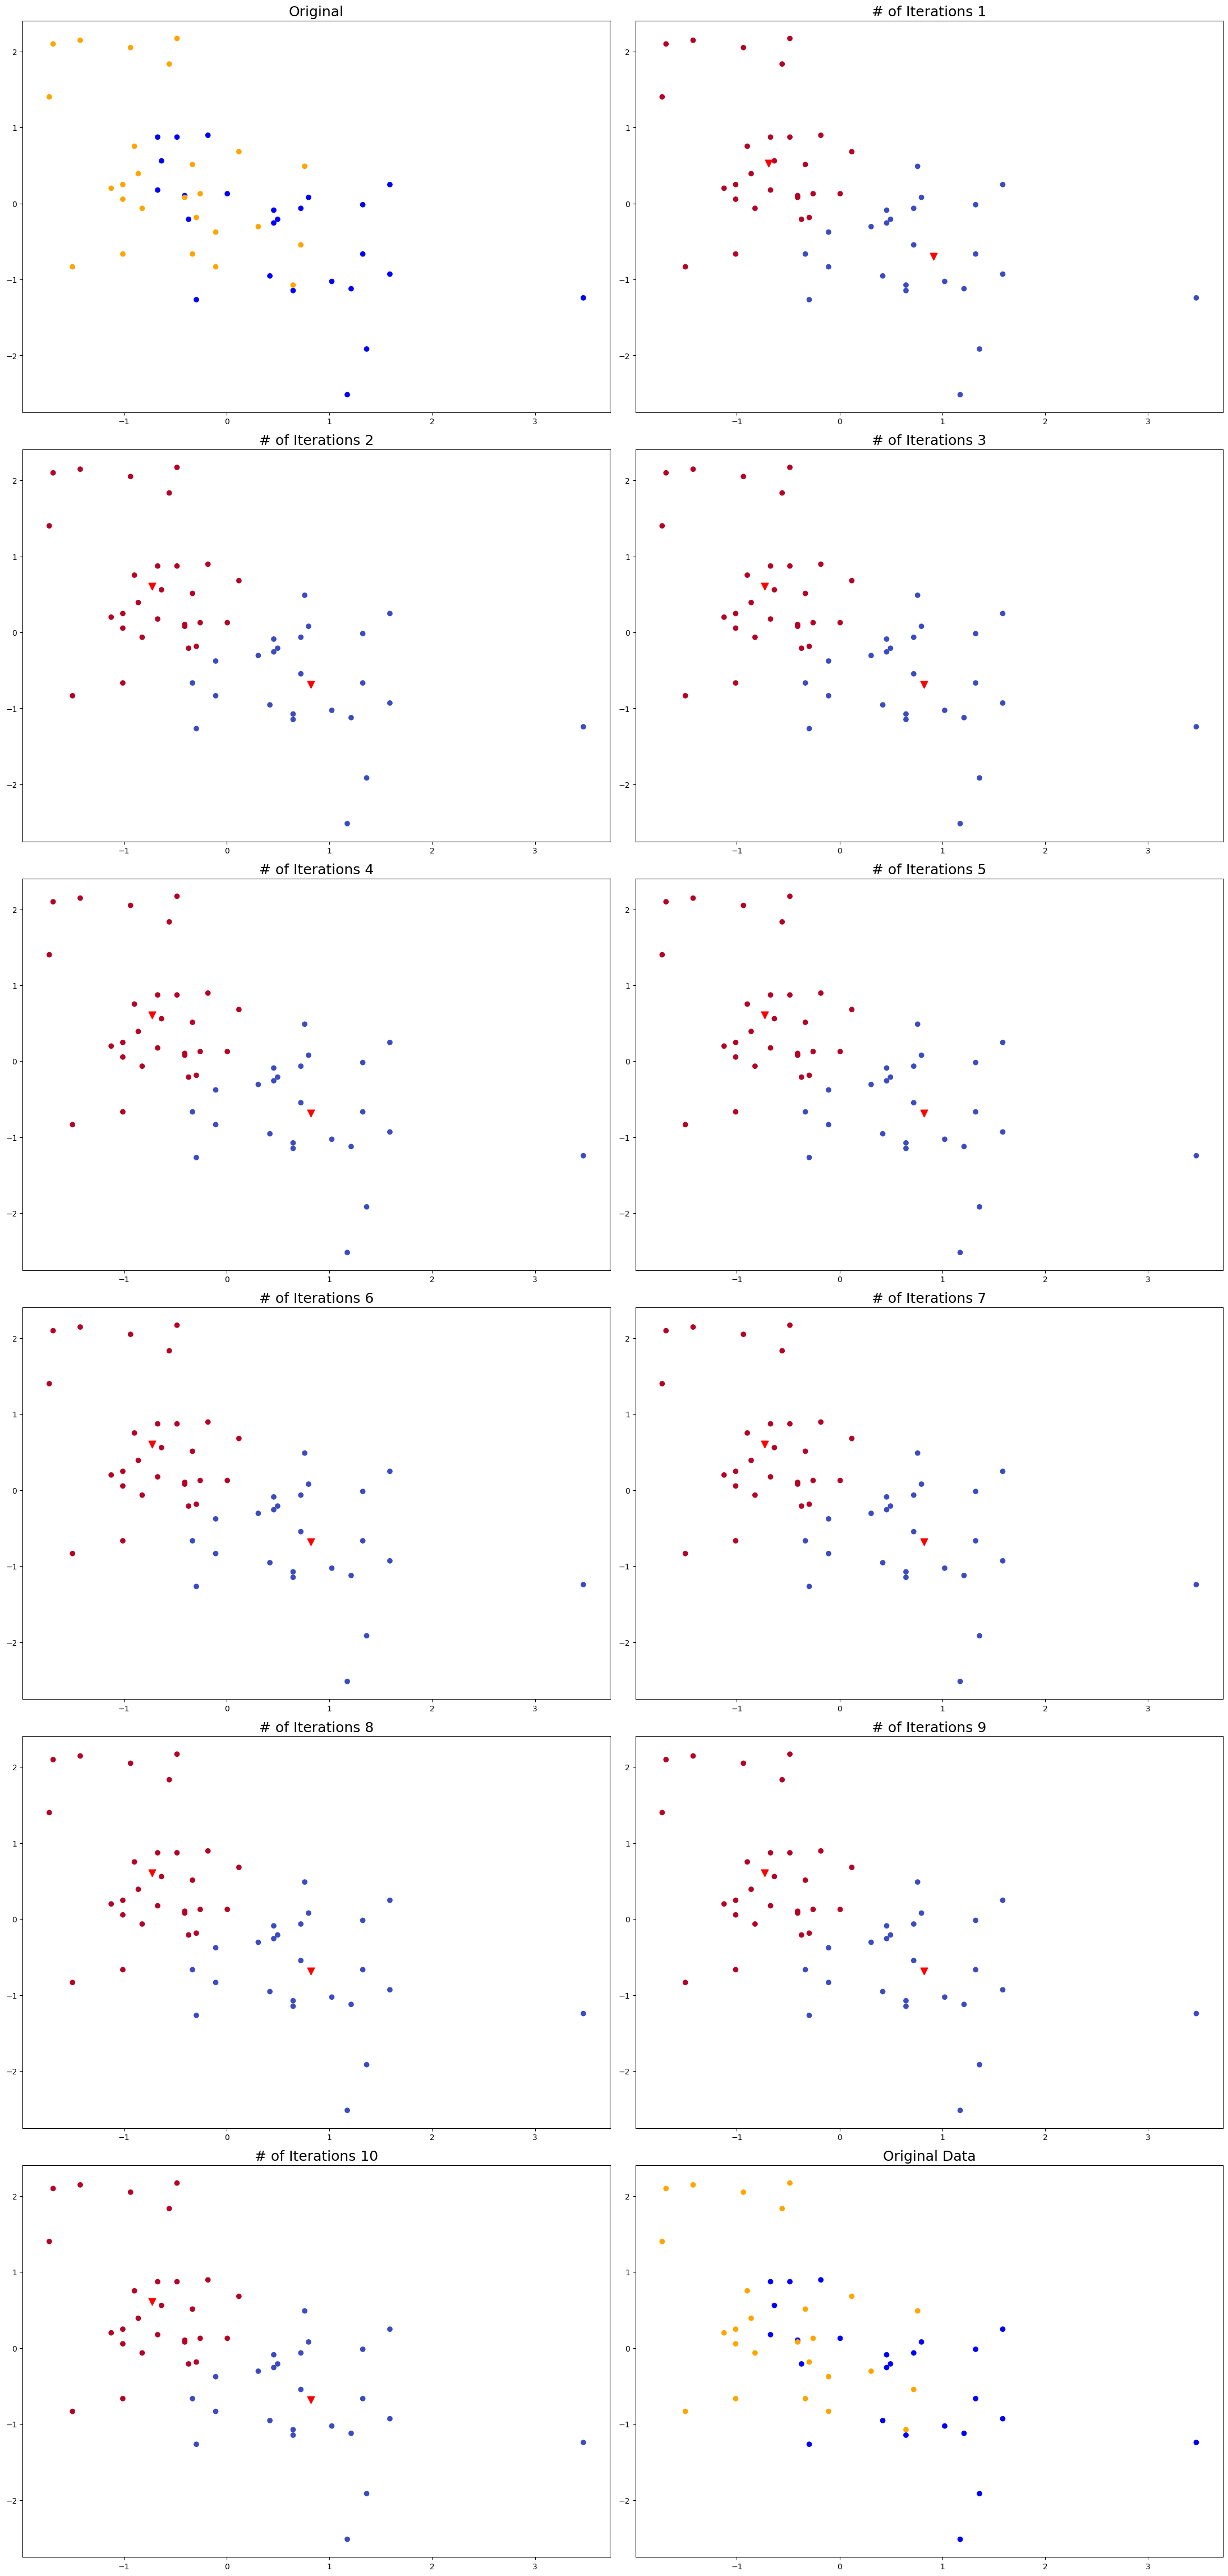

In [15]:
df_cluster2 = df_cluster[['Uninsured', 'preventative_care']]

color_map1 = {
    'Low': 'blue',
    'Medium or high': 'orange'    
}

plt.figure(figsize=(22,84))

m=11
for i in range(1,m):
    km=KMeans(n_clusters=2, max_iter=2*i-1,init='random', n_init=1, random_state=101)
    km.fit(df_cluster2)
    labels=km.labels_
    centers=km.cluster_centers_
    plt.subplot(m,2,i+1)
    plt.scatter(df_cluster['Uninsured'],df_cluster['preventative_care'],
                c=labels, cmap='coolwarm')
    plt.scatter(x=centers[:,0],y=centers[:,1],color='r', marker='v',s=82)
    plt.title("# of Iterations {}".format(i), fontsize=18)
    #Output the cluster designation
    if i==(m-1):
       df_state_std['cluster_uninsured_pcare'] = km.fit_predict(df_cluster2)

plt.subplot(m,2,1)
plt.scatter(df_cluster['Uninsured'],df_cluster['preventative_care'],
            c=df_cluster['good_immun_cat'].map(color_map1), cmap='coolwarm')
plt.title("Original",fontsize=18)

plt.subplot(m,2,m+1)
plt.scatter(df_cluster['Uninsured'],df_cluster['preventative_care'],
            c=df_cluster['good_immun_cat'].map(color_map1), cmap='coolwarm')
plt.title("Original Data",fontsize=18)

# Save the plot
plt.tight_layout()
plt.savefig('Q2_uninsured_pcare_good_immun_kmeans.png', dpi=300)  
plt.show()


In [16]:
df_state_std['cluster_uninsured_pcare'].value_counts()

cluster_uninsured_pcare
1    27
0    24
Name: count, dtype: int64

Confusion matrix:
 [[17  8]
 [ 7 19]]
Best Accuracy: 0.7059
Misclassification Rate: 0.2941


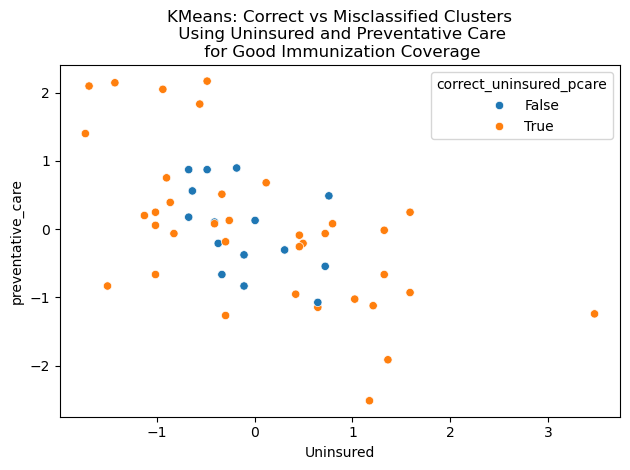

In [17]:
#True labels and predicted cluster labels

value_map = {
    'Low': 0,
    'Medium or high': 1
}

true_labels = df_state_std['good_immun_cat'].map(value_map)
cluster_labels = df_state_std['cluster_uninsured_pcare']

#Confusion matrix
cm = confusion_matrix(true_labels, cluster_labels)
print("Confusion matrix:\n", cm)

#Evaluate both possible cluster label assignments
accuracy1 = accuracy_score(true_labels, cluster_labels)
accuracy2 = accuracy_score(true_labels, 1 - cluster_labels)

#Use the mapping with higher accuracy
if accuracy1 >= accuracy2:
    best_labels = cluster_labels
    best_accuracy = accuracy1
else:
    best_labels = 1 - cluster_labels
    best_accuracy = accuracy2

#Misclassification rate
misclassification_rate = 1 - best_accuracy
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Misclassification Rate: {misclassification_rate:.4f}")

#Mark correct classifications
df_state_std['correct_uninsured_pcare'] = (true_labels == best_labels)

sns.scatterplot(data=df_state_std, x='Uninsured', y='preventative_care', hue='correct_uninsured_pcare')
plt.title('KMeans: Correct vs Misclassified Clusters\n Using Uninsured and Preventative Care\n for Good Immunization Coverage')
plt.tight_layout()
plt.savefig('Q2_uninsured_pcare_good_immun_kmeans_correct.png', dpi=300)  
plt.show()

In [18]:
#Retry using a hierarchical clustering model
hc = AgglomerativeClustering(n_clusters=2, linkage='ward')
cluster_labels = hc.fit_predict(df_cluster2)

#Assign the resulting cluster labels to the original dataframe
df_state_std['cluster_hc_uninsured_pcare'] = cluster_labels

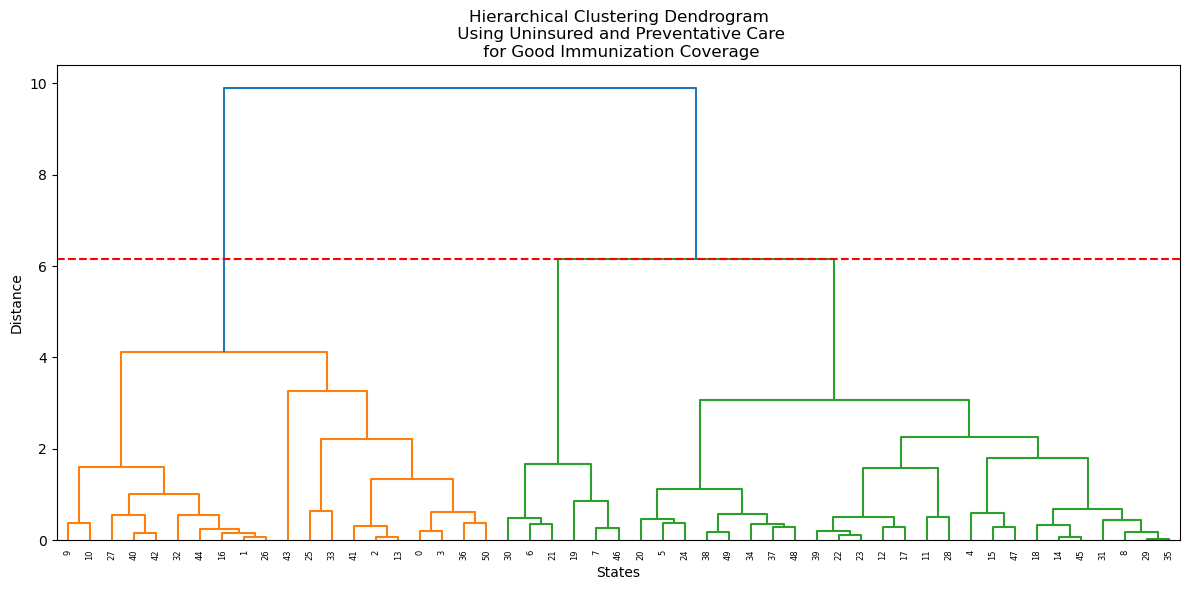

In [19]:
plt.figure(figsize=(12, 6))
#Compute the linkage matrix using ward method
Z = sch.linkage(df_cluster2, method='ward') 
dendrogram = sch.dendrogram(Z)
#Add a line at 2 clusters
plt.axhline(y=Z[-2, 2], c='red', linestyle='--', label='Cut for 2 clusters')
plt.title('Hierarchical Clustering Dendrogram\n Using Uninsured and Preventative Care\n for Good Immunization Coverage')
plt.xlabel('States')
plt.ylabel('Distance')
plt.tight_layout()
plt.savefig('Q2_uninsured_pcare_good_immun_dendrogram.png', dpi=300)  
plt.show()


#By default, fcluster() returns labels 1 and 2, rather than 0 and 1. 
#Recode to 0/1 by subtracting 1
df_state_std['cluster_2_hc_uninsured_pcare'] = fcluster(Z, t=2, criterion='maxclust') - 1

In [20]:
df_state_std['cluster_2_hc_uninsured_pcare'].value_counts()

cluster_2_hc_uninsured_pcare
1    31
0    20
Name: count, dtype: int64

Confusion matrix:
 [[16  9]
 [ 4 22]]
Best Accuracy: 0.7451
Misclassification Rate: 0.2549


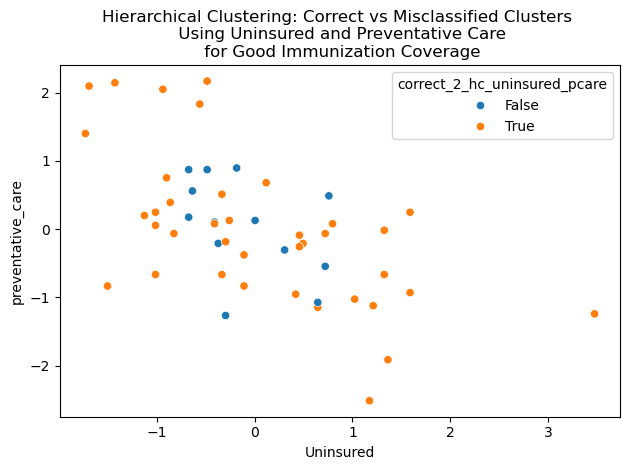

In [21]:
value_map2 = {
    'Low': 0,
    'Medium or high': 1
}

#True labels and predicted cluster labels
true_labels = df_state_std['good_immun_cat'].map(value_map2)
cluster_labels = df_state_std['cluster_2_hc_uninsured_pcare']

#Confusion matrix
cm = confusion_matrix(true_labels, cluster_labels)
print("Confusion matrix:\n", cm)

#Evaluate both possible cluster label assignments
accuracy1 = accuracy_score(true_labels, cluster_labels)
accuracy2 = accuracy_score(true_labels, 1 - cluster_labels)

#Use the mapping with higher accuracy
if accuracy1 >= accuracy2:
    best_labels = cluster_labels
    best_accuracy = accuracy1
else:
    best_labels = 1 - cluster_labels
    best_accuracy = accuracy2

#Misclassification rate
misclassification_rate = 1 - best_accuracy
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Misclassification Rate: {misclassification_rate:.4f}")

#Mark correct classifications
df_state_std['correct_2_hc_uninsured_pcare'] = (true_labels == best_labels)

sns.scatterplot(data=df_state_std, x='Uninsured', y='preventative_care', hue='correct_2_hc_uninsured_pcare')
plt.title('Hierarchical Clustering: Correct vs Misclassified Clusters \n Using Uninsured and Preventative Care\n for Good Immunization Coverage')
plt.tight_layout()
plt.savefig('Q2_uninsured_pcare_good_immun_hc_correct.png', dpi=300)  
plt.show()